In [69]:
import os
import psycopg2
import datetime

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

os.chdir(r'C:\users\barby\downloads')

%matplotlib inline

km_in_a_mile = 1.60934

def readConfig(key):
    config = pd.read_table(r'c:\users\barby\documents\config.txt', header = None)
    config = [c.split('=') for c in config[0]]
    out = [c[1] for c in config if c[0] == key][0]
    return(out)

def dbGetQuery(q):
    pw = readConfig('pw')
    conn_string = "host='kavdb.c9lrodma91yx.us-west-2.rds.amazonaws.com' dbname='kavdb' user='lkavenagh' password='" + pw + "'"
    conn = psycopg2.connect(conn_string)
    conn.autocommit = True
    dat = pd.read_sql(q, conn)
    conn.close()
    return(dat)

In [25]:
dat = dbGetQuery("SELECT * FROM runs.activities")
dat['year'] = [c.year for c in dat.start_date]
dat['doy'] = [c.timetuple().tm_yday for c in dat.start_date]
dat = dat.sort_values('start_date')
dat['distance_miles'] = [(c/1000)/km_in_a_mile for c in dat.distance]
dat['ytd_distance'] = dat.groupby('year', as_index = False).cumsum()['distance_miles']

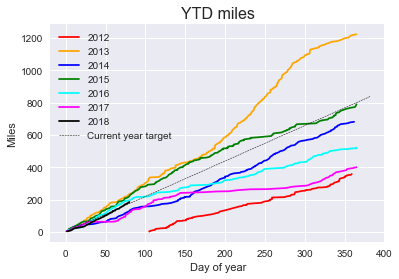

In [52]:
sns.set_style('darkgrid')
fig, ax = plt.subplots()

target = 800

colors = ['red', 'orange', 'blue', 'green', 'cyan', 'magenta', 'black']

for i,y in enumerate(sorted(list(set(dat.year)))):
    ax.plot(dat.loc[dat.year == y, 'doy'], 
            dat.loc[dat.year == y, 'ytd_distance'], 
            color = colors[i],
            label = y)

x = range(int(ax.get_xlim()[1]))
y = [(target / max(dat.doy)) * x for x in x]
ax.plot(x, y, color = 'black', ls = '--', label = 'Current year target', linewidth = 0.5)
ax.legend(loc = 'best')
ax.set_title('YTD miles', fontsize = 16)
ax.set_ylabel('Miles')
ax.set_xlabel('Day of year')

In [85]:
today = datetime.datetime.now().date()
x = (today - datetime.date(today.year, 1, 1)).days + 1
print('Today: ' + str(max(dat.start_date).date()) + ' (day ' + str(dat.loc[dat.start_date == max(dat.start_date), 'doy'][0]) + ')')
today_target = (target/max(dat.doy)) * x
actual = dat.loc[dat.start_date == max(dat.start_date), 'ytd_distance'][0]
print('Target miles: ' + str(round(today_target,2)))
print('Actual miles: ' + str(round(actual,2)))

if actual > today_target:
    print('Surplus: ' + str(round(actual - today_target,2)))
else:
    print('Deficit: ' + str(round(actual - today_target,2)))


Today: 2018-03-21 (day 80)
Target miles: 175.34
Actual miles: 184.65
Surplus: 9.3
